In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
import bs4
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Kospi200

In [2]:
index_cd='KPI200'
page_n=1
naver_index='https://finance.naver.com/sise/sise_index_day.nhn?code='+index_cd+'&page='+str(page_n) #1장 주소
source = urlopen(naver_index).read() #url 열기

In [3]:
source = bs4.BeautifulSoup(source,'html.parser')
print(source.prettify()) # 보기 편하게 출력

<html lang="ko">
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <title>
   네이버 금융
  </title>
  <link href="/css/newstock.css?20200917142109" rel="stylesheet" type="text/css"/>
  <link href="/css/common.css?20200917142109" rel="stylesheet" type="text/css"/>
  <link href="/css/layout.css?20200917142109" rel="stylesheet" type="text/css"/>
  <link href="/css/main.css?20200917142109" rel="stylesheet" type="text/css"/>
  <link href="/css/newstock2.css?20200917142109" rel="stylesheet" type="text/css"/>
  <link href="/css/newstock3.css?20200917142109" rel="stylesheet" type="text/css"/>
  <link href="/css/world.css?20200917142109" rel="stylesheet" type="text/css"/>
 </head>
 <body>
  <script src="/js/jindo.min.ns.1.5.3.euckr.js?20200917142109" type="text/javascript">
  </script>
  <script src="/js/lcslog.js?20200917142109" type="text/javascript">
  </script>
  <!-- 일별시세 -->
  <div class="box_type_m">
   <h4 class="top_tlt" style="text-align:left;">
    <em>
   

In [4]:
source.find_all('table')[0].find_all('tr')[2].find_all('td')[0]

<td class="date">2020.09.29</td>

In [5]:
d=source.find_all('td',class_='date')[0].text #td class이름이 있을때
d

'2020.09.29'

In [6]:
import datetime as dt
def date_format(d): #python 에 맞는 날짜 형식으로 바꾸기
    d=str(d).replace('-','.') 
    yyyy=int(d.split('.')[0]) 
    mm=int(d.split('.')[1])
    dd=int(d.split('.')[2])
    
    this_date=dt.date(yyyy,mm,dd)
    return this_date
date_format('2020.05.15')

datetime.date(2020, 5, 15)

In [7]:
# /html/body/div/table[1]/tbody/tr[3]/td[2]
this_close = source.find_all('table')[0].find_all('tr')[2].find_all('td')[1].text  # 종가 받아오는(table 생략 가능)
this_close=this_close.replace(',','') #쉼표 제거 -> 1000이상 넘어갈때
this_close=float(this_close)

In [8]:
dates=source.find_all('td',class_='date')
prices=source.find_all('td',class_='number_1')

In [9]:
# 한페이지 날짜 및 종가 뽑기
for n in range(len(dates)):
    this_date = dates[n].text
    this_date= date_format(this_date)
    
    this_close=prices[n*4].text # 종가만 추출 - > 종가는 4의 배수에 있음
    this_close = this_close.replace(',','')
    this_close=float(this_close)
    print(this_date,this_close)

2020-09-29 309.44
2020-09-28 307.03
2020-09-25 303.57
2020-09-24 302.48
2020-09-23 309.64
2020-09-22 308.82


In [10]:
paging=source.find('td',class_='pgRR').find('a')['href']
paging

'/sise/sise_index_day.nhn?code=KPI200&page=608'

In [11]:
paging=paging.split('&')[1].split('=')[1] # 맨 마지막 숫자까지 추출
last_page=int(paging)
last_page

608

In [12]:
def historical_index_naver(index_cd,start_date='',end_date='',page_n=1,last_page=0): #날짜 지정하면 그 날의 종가 지수 출력(kospi)
    if start_date:
        start_date=date_format(start_date)  #date포맷으로 변환
    else:
        start_date=dt.date.today()  #없으면 오늘로 지정
    if end_date:
        end_date=date_format(end_date)
    else:
        end_date=dt.date.today()
        
    naver_index='https://finance.naver.com/sise/sise_index_day.nhn?code='+index_cd+'&page='+str(page_n)
    
    source=urlopen(naver_index).read()  #지정한 페이지에서 코드 읽기
    source=bs4.BeautifulSoup(source,'html.parser') #뷰티풀 수프로 태그별로 코드 분류    
    
    dates=source.find_all('td',class_='date')  #<td class='date'>태그에서 날짜 수집
    prices=source.find_all('td',class_='number_1')  #<td class='number_1'>태그에서 종가 수집
    
    for n in range(len(dates)):  #dates 개수만큼 반복
        if dates[n].text.split('.')[0].isdigit(): # 날짜가 숫자형이면
            #날짜처리
            this_date=dates[n].text
            this_date=date_format(this_date)
            
            if this_date<= end_date and this_date>=start_date:  #start_date 와 end_date 사이에서 데이터 처리
                #종가처리
                this_close=prices[n*4].text
                this_close=this_close.replace(',','')
                this_close=float(this_close)
                
                #딕셔너리에 저장
                historical_prices[this_date]=this_close
            elif this_date<start_date:
                return historical_prices
    #페이지 네비게이션
    if last_page==0:
        last_page = source.find('td',class_='pgRR').find('a')['href']
        #마지막 페이지 주소추출
        last_page=last_page.split('&')[1]
        last_page=last_page.split('=')[1]
        last_page=int(last_page)
    if page_n<last_page:
        page_n+=1
        historical_index_naver(index_cd,start_date,end_date,page_n,last_page) # 재귀 알고리즘
    
    return historical_prices

In [13]:
index_cd = 'KPI200'
historical_prices = dict()
kpi200=historical_index_naver(index_cd,'2018-5-4','2020-07-06')
tmp={'KPI200':kpi200}
data=pd.DataFrame(tmp)
data

,KPI200
2018-05-04,316.75
2018-05-08,315.87
2018-05-09,314.42
2018-05-10,317.31
2018-05-11,318.51
...,...
2020-06-30,280.09
2020-07-01,280.26
2020-07-02,283.86
2020-07-03,285.89


# K10

In [14]:
url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd='
k10_component=['005930','000660','005935','207940','068270','005380','035420','012330','051910','055550']
'''
한국거래소 시가총액 상위 10종목
005930 삼성전자
000660 SK하이닉스
005935 삼성전자우
207940 삼성바이오로직스
068270 셀트리온
005380 현대차
035420 NAVER
012330 현대모비스
051910 LG화학
055550 신한지주

'''

'\n한국거래소 시가총액 상위 10종목\n005930 삼성전자\n000660 SK하이닉스\n005935 삼성전자우\n207940 삼성바이오로직스\n068270 셀트리온\n005380 현대차\n035420 NAVER\n012330 현대모비스\n051910 LG화학\n055550 신한지주\n\n'

In [15]:
source=urlopen(url_float+k10_component[0]).read()
soup=bs4.BeautifulSoup(source,'html.parser')
soup


<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">

<html lang="ko">
<head>
<title>온라인기업정보 - 기업모니터 - 기업개요(삼성전자)</title>
<link href="/favicon.ico" rel="shortcut icon"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<script language="javascript" src="/include/domain.js" type="text/javascript"></script>
<!--[if (!IE) | (gt IE 8)]>
    	<meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" />
    <![endif]-->
<!--[if IE 6]>
            <link href="/include/only_ie6.css" type="text/css" rel="stylesheet"/>
        <![endif]-->
<!--[if lt IE 8]>
            <link href="/include/lt_ie8.css" type="text/css" rel="stylesheet"/>
        <![endif]-->
<link href="/v1/include/css?v=q7Pq73b9jj00gmFmOVUSxzXv_5FtLNW9qxkqFwJqh-g1" rel="stylesheet"/>
<link href="/v1/include/css1?v=2Kc54WAY0-YKwI0WYHBphRe4FmbyttZ0_0A_hAhAjHc1" rel="stylesheet"/>
<link href="/v1/include/csscrawler?v=6j20PRFQZOF_cQY

In [16]:
tmp=soup.find(id='cTB11').find_all('tr')[6].td.text
tmp=tmp.replace('\r','')
tmp=tmp.replace('\n','')
tmp=tmp.replace('\t','')
tmp=re.split('/',tmp)

In [17]:
tmp[0].strip().replace(',','')

'5969782550주'

In [18]:
outstanding=tmp[0].strip().replace(',','').replace('주','')
floating=tmp[1].replace(' ','').replace('%','')
outstanding=int(outstanding)
floating=float(floating)

In [19]:
def stock_info(stock_cd): # 상장주식과 유동비율 주가 이름을 구하는 함수
    url_float='http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd='+stock_cd
    source = urlopen(url_float).read()
    soup = bs4.BeautifulSoup(source,'html.parser')
    
    # //*[@id="cTB11"]/tbody/tr[7]/td
    tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
    tmp= tmp.replace('\r','')
    tmp= tmp.replace('\t','')
    tmp= tmp.replace('\n','')
    
    tmp=re.split('/',tmp)
    
    outstanding=tmp[0].replace(' ','')
    outstanding=outstanding.replace('주','')
    outstanding=outstanding.replace(',','')
    outstanding=int(outstanding)
    
    floating= tmp[1].replace(' ','')
    floating=floating.replace('%','')
    floating=float(floating)
    
    name=soup.find(id='pArea').find('div').find('div').find('tr').find('td').find('span').text
    
    k10_outstanding[stock_cd]=outstanding
    k10_floating[stock_cd]=floating
    k10_name[stock_cd]=name

In [20]:
k10_outstanding=dict()
k10_floating=dict()
k10_name=dict()
for stock_cd in k10_component:
    stock_info(stock_cd)

In [21]:
def historical_stock_naver(stock_cd,start_date='',end_date='',page_n=1,last_page=0):   #날짜 지정하면 그 날의 종가 지수 출력
    if start_date:
        start_date=date_format(start_date)  #date포맷으로 변환
    else:
        start_date=dt.date.today()  #없으면 오늘로 지정
    if end_date:
        end_date=date_format(end_date)
    else:
        end_date=dt.date.today()
        
    naver_stock='https://finance.naver.com/item/sise_day.nhn?code='+stock_cd+'&page='+str(page_n)
    
    source=urlopen(naver_stock).read()  #지정한 페이지에서 코드 읽기
    source=bs4.BeautifulSoup(source,'html.parser') #뷰티풀 수프로 태그별로 코드 분류    
    
    dates=source.find_all('span',class_='tah p10 gray03')  #날짜 수집
    prices=source.find_all('td',class_='num')  #종가 수집
    
    for n in range(len(dates)):  #dates 개수만큼 반복
        if len(dates)>0: 
            #날짜처리
            this_date=dates[n].text
            this_date=date_format(this_date)
            
            if this_date<= end_date and this_date>=start_date:  #start_date 와 end_date 사이에서 데이터 처리
                #종가처리
                this_close=prices[n*6].text
                this_close=this_close.replace(',','')
                this_close=float(this_close)
                
                #딕셔너리에 저장
                #historical_prices=dict()
                historical_prices[this_date]=this_close
            elif this_date<start_date:
                return historical_prices
    #페이지 네비게이션
    if last_page==0:
        last_page = source.find_all('table')[1].find('td',class_='pgRR').find('a')['href']
        #마지막 페이지 주소추출
        last_page=last_page.split('&')[1]
        last_page=last_page.split('=')[1]
        last_page=float(last_page)
    if page_n<last_page:
        page_n+=1
        historical_stock_naver(stock_cd,start_date,end_date,page_n,last_page)
    
    return historical_prices
k10_component=['005930','000660','005935','207940','068270','005380','035420','012330','051910','055550']
k10_historical_prices=dict()

In [22]:
for stock_cd in k10_component:   
    historical_prices=dict()
    start_date='2018-5-4'
    end_date='2020-7-6'
    historical_stock_naver(stock_cd,start_date,end_date)
    
    k10_historical_prices[stock_cd]=historical_prices
k10_historical_prices=pd.DataFrame(k10_historical_prices)
k10_historical_prices.head(3)

,005930,000660,005935,207940,068270,005380,035420,012330,051910,055550
2020-07-06,55000.0,86000.0,47950.0,754000.0,305500.0,101500.0,281500.0,204500.0,509000.0,30300.0
2020-07-03,53600.0,85400.0,46900.0,771000.0,309500.0,99200.0,277500.0,195500.0,507000.0,30050.0
2020-07-02,52900.0,84400.0,46650.0,786000.0,308500.0,99000.0,277000.0,194500.0,496000.0,29900.0


In [23]:
k10_historical_prices = k10_historical_prices.sort_index()

In [24]:
tmp = {'Outstanding':k10_outstanding,'Floating': k10_floating,'Price':k10_historical_prices.iloc[0],'Name':k10_name}
k10_info=pd.DataFrame(tmp)
k10_info

,Outstanding,Floating,Price,Name
000660,728002365,73.56,83000.0,SK하이닉스
005380,213668187,64.41,158000.0,현대차
005930,5969782550,74.61,51900.0,삼성전자
005935,5969782550,74.61,41050.0,삼성전자
012330,95054694,67.08,235000.0,현대모비스
035420,164263395,75.76,717000.0,NAVER
051910,70592343,64.29,341000.0,LG화학
055550,516526835,81.90,46800.0,신한지주
068270,134993738,75.69,250000.0,셀트리온
207940,66165000,24.75,359500.0,삼성바이오로직스


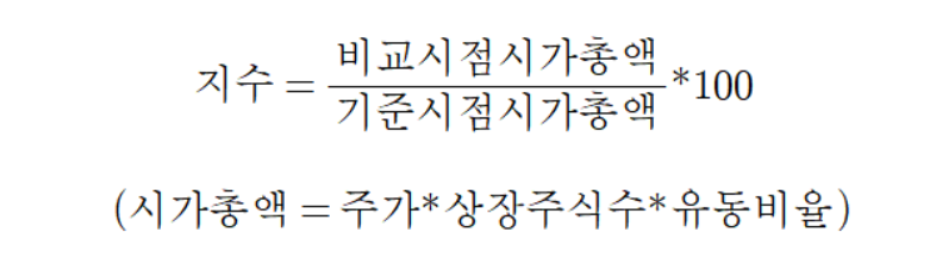

In [25]:
# 시가총액 = 주가 * 상장주식 수
k10_info['Market Cup'] = k10_info['Outstanding'] * k10_info['Price'] * 0.01
# 유동비율을 반영한 시가총액 = 주가 * 상장주식 수 * 유동비율
k10_info['f Market Cup']= k10_info['Outstanding'] * k10_info['Floating'] *k10_info['Price'] * 0.01

k10_historical_mc = k10_historical_prices * k10_info['Outstanding'] * k10_info['Floating'] * 0.01
k10_historical_mc.head() #일자별 유동 비율을 반영한 시가 총액


,000660,005380,005930,005935,012330,035420,051910,055550,068270,207940
2018-05-04,4.444804e+13,2.174454e+13,2.311654e+14,1.828389e+14,1.498423e+13,8.922774e+13,1.547588e+13,1.979806e+13,2.554419e+13,5.887114e+12
2018-05-08,4.471580e+13,2.146929e+13,2.342833e+14,1.870703e+14,1.498423e+13,9.096999e+13,1.499935e+13,1.986152e+13,2.411372e+13,6.067248e+12
2018-05-09,4.466225e+13,2.112523e+13,2.267114e+14,1.806119e+14,1.498423e+13,9.047220e+13,1.540781e+13,1.975576e+13,2.646378e+13,6.517583e+12
2018-05-10,4.594749e+13,2.091880e+13,2.298292e+14,1.823935e+14,1.476106e+13,8.960108e+13,1.543050e+13,2.030570e+13,2.646378e+13,6.378389e+12
2018-05-11,4.610815e+13,2.105642e+13,2.284930e+14,1.823935e+14,1.511176e+13,8.922774e+13,1.565742e+13,2.017879e+13,2.656596e+13,6.329261e+12


In [26]:
k10=pd.DataFrame()
k10['K10 Market Cap']=k10_historical_mc.sum(axis=1) # 일자별 시가총액의 합
k10['K10'] = k10['K10 Market Cap']/k10['K10 Market Cap'][0] * 100 # k10지수 산출

In [27]:
data = pd.concat([data,k10],axis=1)
data.drop('K10 Market Cap',axis=1,inplace=True)

In [28]:
data.head()

,KPI200,K10
2018-05-04,316.75,100.000000
2018-05-08,315.87,101.139667
2018-05-09,314.42,99.323922
2018-05-10,317.31,100.140587
2018-05-11,318.51,100.001207


In [29]:
data['kpi200'] = data['KPI200']/data['KPI200'][0]*100
data.drop('KPI200',axis=1,inplace=True)
data.head()

,K10,kpi200
2018-05-04,100.000000,100.000000
2018-05-08,101.139667,99.722178
2018-05-09,99.323922,99.264404
2018-05-10,100.140587,100.176796
2018-05-11,100.001207,100.555643


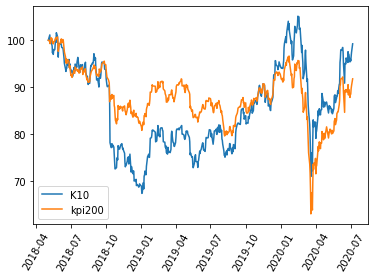

In [30]:
import matplotlib.pyplot as plt
data.plot()
plt.xticks(rotation=60)
plt.show()

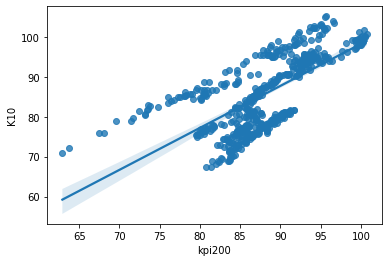

In [31]:
sns.regplot(data['kpi200'],data['K10'])

In [32]:
data.corr()

,K10,kpi200
K10,1.000000,0.674781
kpi200,0.674781,1.000000


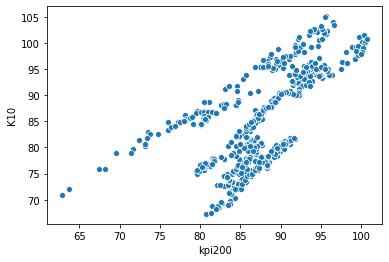

In [33]:
sns.scatterplot(data['kpi200'],data['K10'])

plt.show()

# Modeling
- Prophet

In [34]:
from fbprophet import Prophet

In [35]:
prop = data.reset_index()
train_num = int(len(prop) * 0.7)
train_df = prop[:train_num]
test_df = prop[train_num:]

In [36]:
k10_train = train_df[['index','K10']]
k10_train.columns = ['ds','y']

In [37]:
m = Prophet()
m.fit(k10_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [38]:
k10_future = m.make_future_dataframe(periods = len(test_df))
forecast = m.predict(k10_future)
forecast.tail() # 주말도 포함되어 있기 때문에 실제 날짜와 다름

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
528,2020-04-16,99.819912,87.979707,112.857081,88.209796,112.961625,0.069892,0.069892,0.069892,0.069892,0.069892,0.069892,0.0,0.0,0.0,99.889804
529,2020-04-17,99.900929,87.636485,112.649891,88.216862,113.196232,-0.014455,-0.014455,-0.014455,-0.014455,-0.014455,-0.014455,0.0,0.0,0.0,99.886474
530,2020-04-18,99.981946,87.802690,113.706945,88.193910,113.430015,0.176326,0.176326,0.176326,0.176326,0.176326,0.176326,0.0,0.0,0.0,100.158272
531,2020-04-19,100.062963,87.764612,113.743950,88.239660,113.659694,0.176326,0.176326,0.176326,0.176326,0.176326,0.176326,0.0,0.0,0.0,100.239289
532,2020-04-20,100.143980,86.556604,113.947342,88.249310,113.879956,-0.172026,-0.172026,-0.172026,-0.172026,-0.172026,-0.172026,0.0,0.0,0.0,99.971954


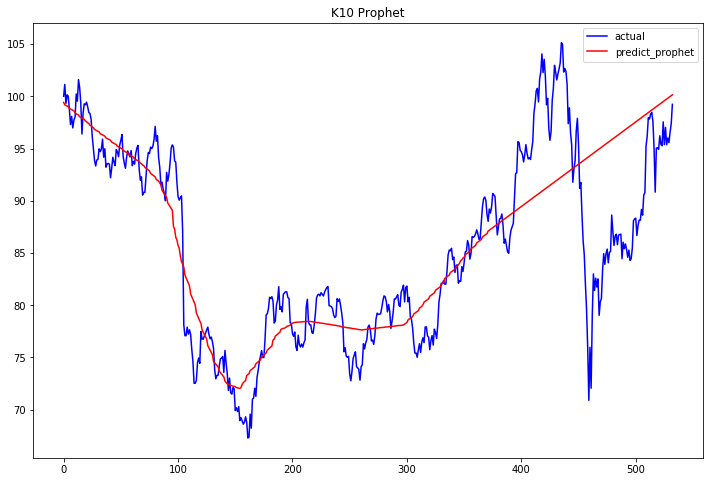

In [39]:
plt.figure(figsize = (12,8))
plt.plot(prop['K10'],color = 'blue',label = 'actual')
plt.plot(forecast['trend'],color='red',label = 'predict_prophet')
plt.title('K10 Prophet')
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error
score_table = pd.DataFrame(columns = ['model','score'])
score = np.round(mean_squared_error(prop['K10'],forecast['trend']),2)
score_table.loc[0,'model'] = 'k10_prophet'
score_table.loc[0,'score'] = score

In [41]:
k200_train = train_df[['index','kpi200']]
k200_train.columns = ['ds','y']
m = Prophet()
m.fit(k200_train)
k200_future = m.make_future_dataframe(periods = len(test_df))
forecast_k200 = m.predict(k10_future)
forecast_k200.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
528,2020-04-16,92.697518,83.817355,102.070365,83.797777,101.673934,0.181132,0.181132,0.181132,0.181132,0.181132,0.181132,0.0,0.0,0.0,92.878650
529,2020-04-17,92.733164,83.238079,101.985026,83.764483,101.810371,0.209054,0.209054,0.209054,0.209054,0.209054,0.209054,0.0,0.0,0.0,92.942218
530,2020-04-18,92.768810,82.975338,101.765508,83.741553,101.877360,-0.440815,-0.440815,-0.440815,-0.440815,-0.440815,-0.440815,0.0,0.0,0.0,92.327994
531,2020-04-19,92.804455,82.924080,101.607910,83.717464,101.951178,-0.440816,-0.440816,-0.440816,-0.440816,-0.440816,-0.440816,0.0,0.0,0.0,92.363640
532,2020-04-20,92.840101,83.231271,102.278780,83.680576,102.028828,0.186161,0.186161,0.186161,0.186161,0.186161,0.186161,0.0,0.0,0.0,93.026262


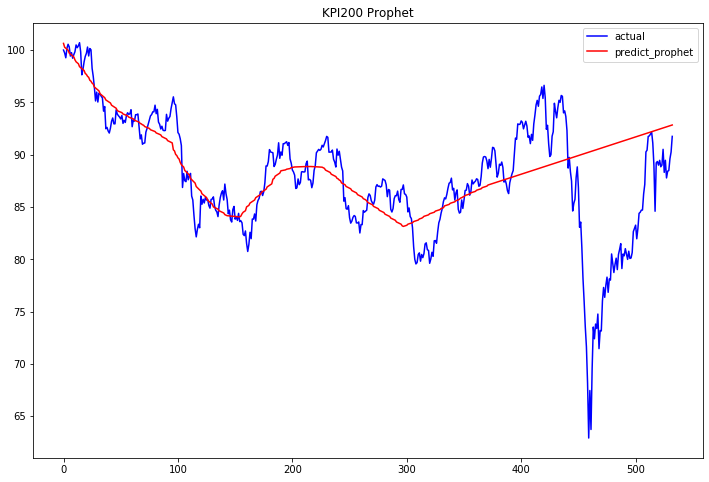

In [42]:
plt.figure(figsize = (12,8))
plt.plot(prop['kpi200'],color = 'blue',label = 'actual')
plt.plot(forecast_k200['trend'],color='red',label = 'predict_prophet')
plt.title('KPI200 Prophet')
plt.legend()
plt.show()

In [43]:
score = np.round(mean_squared_error(prop['kpi200'],forecast_k200['trend']),2)
score_table.loc[1,'model'] = 'k200_prophet'
score_table.loc[1,'score'] = score

- LSTM

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim

In [47]:
def create_sequence(array,seq_length):
    res = []
    if seq_length == 1:
        for i in range(len(array)):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
    else:
        for i in range(len(array)-seq_length-1):
            tmp = array[i:(i+seq_length)]
            res.append(tmp)
    return res

In [59]:
train10 = np.array(k10_train['y'])
train10 = create_sequence(train10,1)
train10 = torch.tensor(train10).float()

In [61]:
k10_test = train_df[['index','K10']]
test10 = np.array(k10_test['K10'])
test10 = create_sequence(test10,1)
test10 = torch.tensor(test10).float()

In [62]:
print(train10.shape)
print(test10.shape)

torch.Size([373, 1])
torch.Size([373, 1])


In [77]:
class RNN(nn.Module):
    def __init__(self,input_size,embedding_size,hidden_size,output_size,num_layers = 1):
        super(RNN,self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.encoder = nn.Embedding(self.input_size,self.embedding_size)
        self.rnn = nn.LSTM(self.embedding_size,self.hidden_size,self.num_layers)
        self.decoder = nn.Linear(self.hidden_size,self.output_size)

    def forward(self,input,hidden,cell):
        out = self.encoder(input.view(1,-1))
        out,(hidden,cell) = self.rnn(out,(hidden,cell))
        out = self.decoder(out.view(batch_size,-1))
        return out,hidden,cell
  
    def init_hidden(self):
        hidden = torch.zeros(self.num_layers,batch_size,self.hidden_size)
        cell = torch.zeros(self.num_layers,batch_size,self.hidden_size)
        return hidden,cell

In [78]:
embedding_size = 60
num_layers = 3
model = RNN(len(train10),embedding_size,len(train10),len(train10),num_layers)

In [79]:
hidden,cell = model.init_hidden
print(hidden.size())

TypeError: cannot unpack non-iterable method object

In [74]:
lr = 0.005
loss_func = nn.MSELoss()
optimizer = optim.Adam(LSTM.parameters(),lr=lr)

TypeError: parameters() missing 1 required positional argument: 'self'